# **Customer Acceptance Prediction for Marketing Campaign**

**1. Introduction**

   **1.1. Project Goal**

  The primary objective of this project is to analyze customer data from a **marketing campaign** and build a **classification model**. This model will predict whether a customer will respond positively to a future campaign offer, helping the marketing team to optimize their strategy and target the right audience more effectively.

**1.2. Data Description**
>The dataset contains information about **2,240 customers**, including their demographics, household composition, spending habits on various product categories, and responses to past marketing campaigns.





In [251]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Environment Setup and Data Loading**

The first steps involve **preparing the Python environment** by importing the necessary libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (scikit-learn, xgboost). The dataset is then loaded from a CSV file into a pandas DataFrame.

In [252]:
# Libraries imported
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [253]:
df = pd.read_csv('/content/drive/MyDrive/marketing_campaign.csv', sep="\t")

**3. Exploratory Data Analysis (EDA) and Preprocessing**

In [254]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [255]:
print(df.describe())


                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000  

In [256]:
print(df.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


**3.1. Initial Data Inspection**
An initial analysis was conducted using **.info(), .describe(), and .isnull().sum()** to understand the **dataset's structure**. Key findings include:

- The dataset has 29 columns and 2,240 entries.

- Most columns are numerical, with three being object types (Education, Marital_Status, Dt_Customer).

- The Income column has 24 missing values from Income.

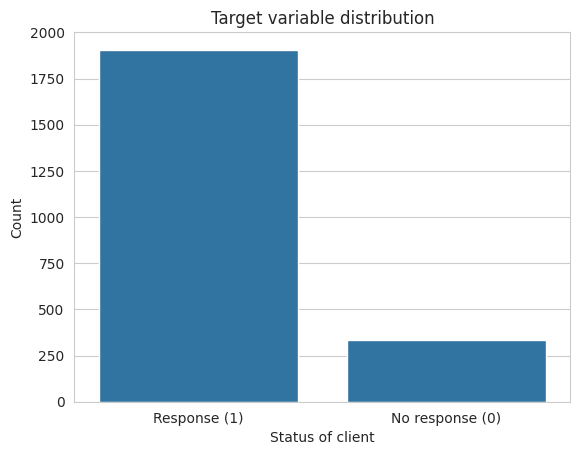

In [257]:
# Bar plot
ax = sns.countplot(data=df, x='Response')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Response (1)', 'No response (0)'])

plt.title('Target variable distribution')
plt.ylabel('Count')
plt.xlabel('Status of client')
plt.show()

**3.2. Target Variable Analysis**

A count plot of the Response variable (the target) was generated. The plot revealed a significant **class imbalance**, with a **much larger number of customers accepting the offer (class 1)** than those who did not (class 0). This imbalance is a critical consideration for model training and evaluation.

In [258]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [259]:
df['Income'] = df['Income'].fillna(0)

In [260]:
actual_year = datetime.now().year
df['Year_Birth'] = actual_year - df['Year_Birth']

In [261]:
df = df.drop(columns=['ID'])

In [262]:
df_numeric = df.select_dtypes(include=['number'])

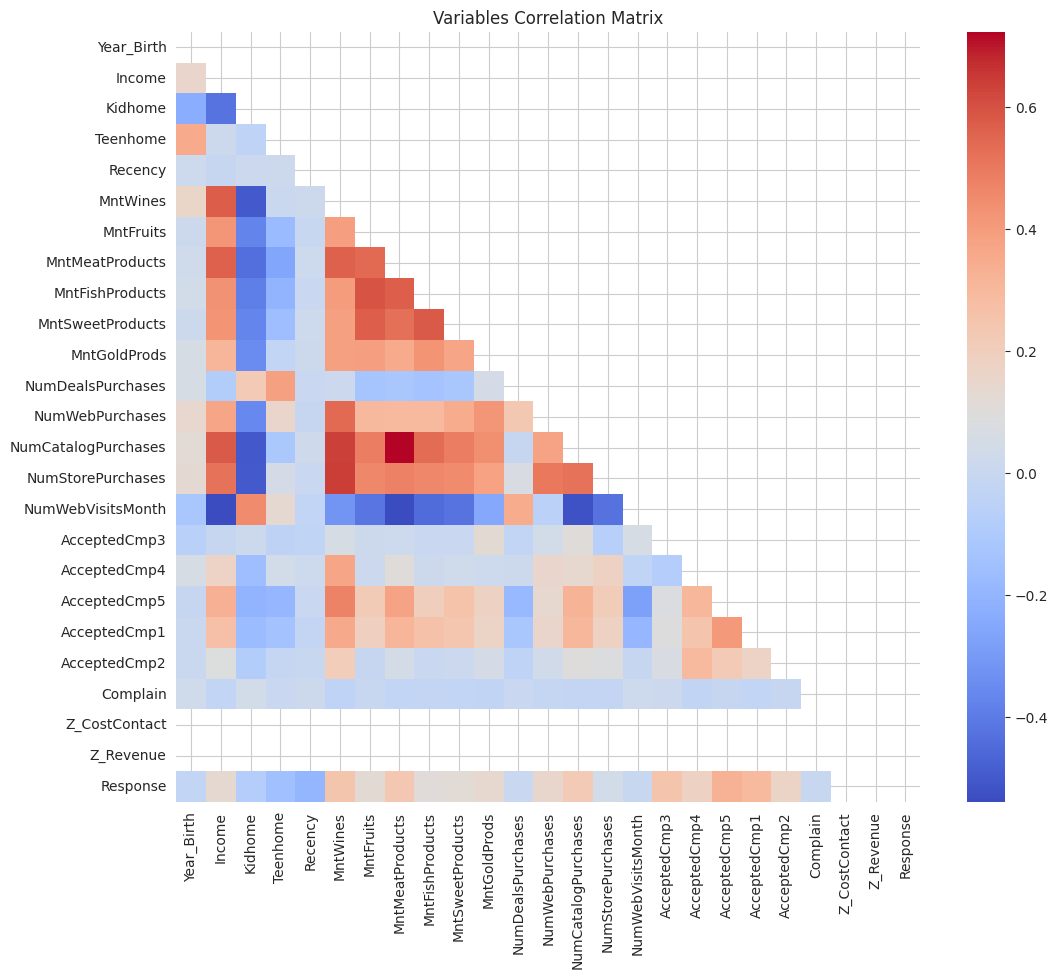


Target variable correlation ('Response'):
Response               1.000000
AcceptedCmp5           0.326634
AcceptedCmp1           0.293982
AcceptedCmp3           0.254258
MntWines               0.247254
MntMeatProducts        0.236335
NumCatalogPurchases    0.220810
AcceptedCmp4           0.177019
AcceptedCmp2           0.169293
NumWebPurchases        0.148730
MntGoldProds           0.139850
Income                 0.136389
MntFruits              0.125289
MntSweetProducts       0.117372
MntFishProducts        0.111331
NumStorePurchases      0.039363
NumDealsPurchases      0.002238
Complain              -0.001707
NumWebVisitsMonth     -0.003987
Year_Birth            -0.021325
Kidhome               -0.080008
Teenhome              -0.154446
Recency               -0.198437
Z_CostContact               NaN
Z_Revenue                   NaN
Name: Response, dtype: float64


In [263]:
plt.figure(figsize=(12, 10))

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Create a mask for the upper triangle to show only the lower half (avoids redundancy)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm') # annot=False para não poluir
plt.title('Variables Correlation Matrix')
plt.show()

# To see the exact correlation values with the target:
print("\nTarget variable correlation ('Response'):")
print(correlation_matrix['Response'].sort_values(ascending=False))

In [264]:
# Check the number of unique values in each column
print("Unique values in Z_CostContact:", df['Z_CostContact'].nunique())
print("Unique values in Z_Revenue:", df['Z_Revenue'].nunique())

# To see the values and their counts
print("\nValue counts for Z_CostContact:\n", df['Z_CostContact'].value_counts())
print("\nValue counts for Z_Revenue:\n", df['Z_Revenue'].value_counts())

Unique values in Z_CostContact: 1
Unique values in Z_Revenue: 1

Value counts for Z_CostContact:
 Z_CostContact
3    2240
Name: count, dtype: int64

Value counts for Z_Revenue:
 Z_Revenue
11    2240
Name: count, dtype: int64


**3.3. Handling Constant and ID Columns**

The columns Z_CostContact and Z_Revenue were checked for unique values. Since they were found to be constant for all customers, they provide no predictive power and were dropped. The ID column was also removed as it is a unique identifier and not a predictive feature.

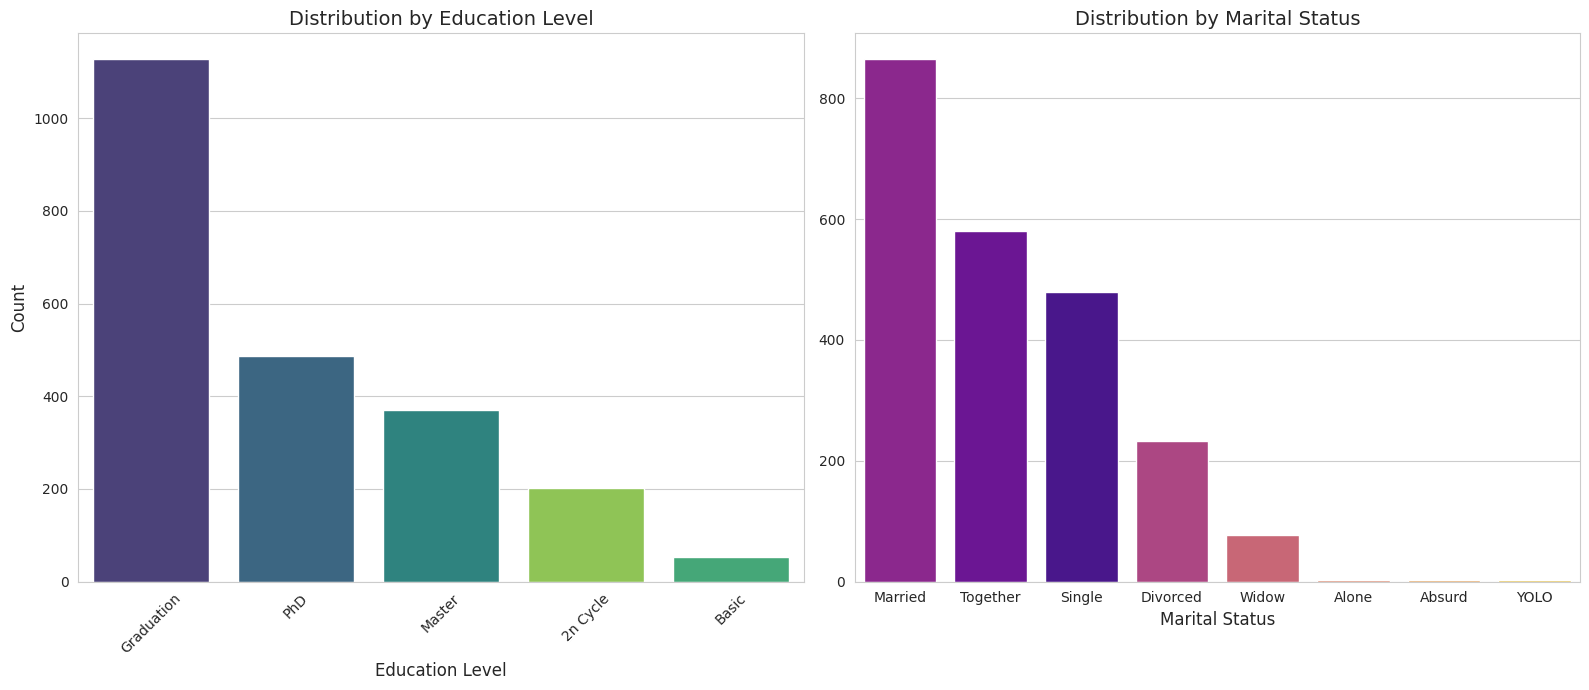

In [265]:
# --- PLOT 2: Distribution of Education and Marital_Status (Bar Charts) ---

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Bar Chart for 'Education'
sns.countplot(
    ax=axes[0],
    data=df,
    x='Education',
    palette='viridis',
    order=df['Education'].value_counts().index,
    hue='Education',
    legend=False
)
axes[0].set_title('Distribution by Education Level', fontsize=14)
axes[0].set_xlabel('Education Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Bar Chart for 'Marital_Status'
sns.countplot(
    ax=axes[1],
    data=df,
    x='Marital_Status',
    palette='plasma',
    order=df['Marital_Status'].value_counts().index,
    # --- FIX APPLIED HERE ---
    hue='Marital_Status',
    legend=False
)
axes[1].set_title('Distribution by Marital Status', fontsize=14)
axes[1].set_xlabel('Marital Status', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [266]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y').dt.year

In [267]:
df['Customer_Tenure'] = actual_year - df['Dt_Customer']

In [268]:
df['Total_children'] = df['Kidhome'] + df['Teenhome']

In [269]:
df['Total_campaings_accepted'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

In [270]:
df['Total_spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

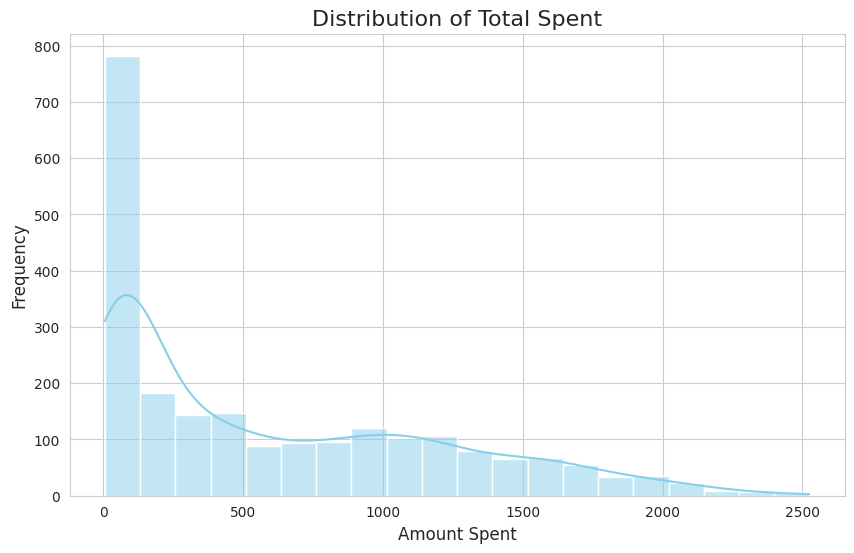

In [271]:
# --- PLOT 1: Distribution of Total_spent (Histogram + KDE) ---
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_spent'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Total Spent', fontsize=16)
plt.xlabel('Amount Spent', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [272]:
df['Total_purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [273]:
boxcox(df['Total_spent'])

(array([15.41142799,  4.49492228, 12.82100944, ..., 14.43806468,
        13.09642064,  8.46323806]),
 np.float64(0.17947022740229895))

In [274]:
df['Total_spent'] = np.log1p(df['Total_spent'])

**4. Feature Engineering**

To improve the model's predictive power, several new features were created from the existing data:

- **Age**: Calculated from Year_Birth to represent the customer's current age.

- **Customer_Tenure**: Calculated from Dt_Customer to represent how many years the person has been a customer.

- **Total_children**: The sum of Kidhome and Teenhome to create a single feature for the number of children in the household.

- **Total_spent**: The sum of all spending columns (Mnt...) to represent the total amount spent by a customer - **treated using logarithmic transformation.**

- **Total_purchases**: The sum of all purchase channel columns (Num...Purchases) to represent the total number of transactions.

- **Total_campaigns_accepted**: The sum of all past campaign acceptance columns (AcceptedCmp...) to create a strong feature representing customer engagement.



In [275]:
df_treated = df.drop(columns=['Dt_Customer', 'Kidhome', 'Teenhome',
                              'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                              'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                              'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                              'Z_CostContact', 'Z_Revenue'])

In [276]:
print("\nPreview of the new columns:")
display(df_treated.head())


Preview of the new columns:


,Year_Birth,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Complain,Response,Customer_Tenure,Total_children,Total_campaings_accepted,Total_spent,Total_purchases
0,68,Graduation,Single,58138.0,58,7,0,1,13,0,0,7.388946,25
1,71,Graduation,Single,46344.0,38,5,0,0,11,2,0,3.332205,6
2,60,Graduation,Together,71613.0,26,4,0,0,12,0,0,6.655440,21
3,41,Graduation,Together,26646.0,26,6,0,0,11,1,0,3.988984,8
4,44,PhD,Married,58293.0,94,5,0,0,11,1,0,6.047372,19


**4.2. Final Cleanup**

After creating the new aggregated features, the original columns used for their creation were dropped to avoid data redundancy and multicollinearity. This resulted in the final, **cleaned DataFrame df_treated** used for modeling.

**5. Model Preparation**

In [277]:
y = df_treated['Response']
X = df_treated.drop(columns=['Response'])

In [278]:
print("Shape the X (features):", X.shape)
print("Shape the y (target):", y.shape)

Shape the X (features): (2240, 12)
Shape the y (target): (2240,)


**5.1. Defining Features (X) and Target (y)**

The dataset was separated into the feature matrix X (all columns except Response) and the target vector y (the Response column).

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**5.2. Splitting into Training and Test Sets**

The data was split into **training (80%)** and **testing (20%)** sets using **train_test_split**. The **stratify=y parameter** was used to ensure that the **proportion of positive and negative classes was the same** in both the training and test sets, which is crucial given the class imbalance.

In [280]:
# Select the numeric columns
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_features)
print("Categoric columns:", categorical_features)

Numeric columns: ['Year_Birth', 'Income', 'Recency', 'NumWebVisitsMonth', 'Complain', 'Customer_Tenure', 'Total_children', 'Total_campaings_accepted', 'Total_spent', 'Total_purchases']
Categoric columns: ['Education', 'Marital_Status']


In [281]:
# Pipeline for numeric datas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Pipeline for categorical datas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [282]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

**5.3. Preprocessing Pipeline**

A ColumnTransformer was created to apply different **preprocessing steps** to numeric and categorical columns:

- **Numeric Transformer:** This pipeline **handles missing values** in numeric columns by **imputing** them with the **median**. It then **scales the data using StandardScaler** to ensure all numeric features have a similar scale.

- **Categorical Transformer:** This pipeline applies **OneHotEncoder** to the **categorical columns** (Education, Marital_Status), **converting them into a numerical format** that the model can understand.

**6. Modeling and Evaluation**

In [283]:
# Create the complete pipeline: preprocessing + model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])


# Train the Pipeline
model_pipeline.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model_pipeline.predict(X_test)

print("Model trained successfully!")

Model trained successfully!


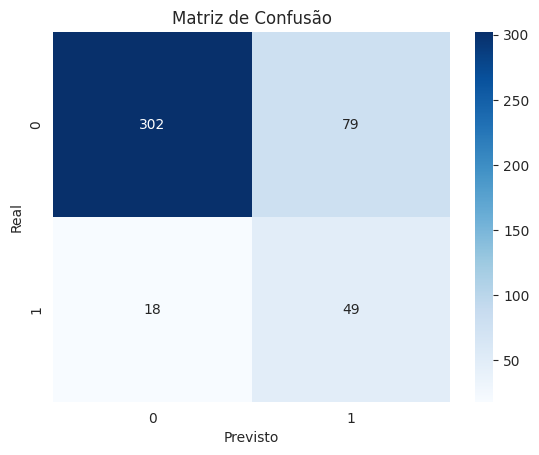

In [284]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [285]:
print(classification_report(y_test, y_pred, target_names=['Response (1)', 'No response (0)']))

                 precision    recall  f1-score   support

   Response (1)       0.94      0.79      0.86       381
No response (0)       0.38      0.73      0.50        67

       accuracy                           0.78       448
      macro avg       0.66      0.76      0.68       448
   weighted avg       0.86      0.78      0.81       448



AUC Score: 0.8696


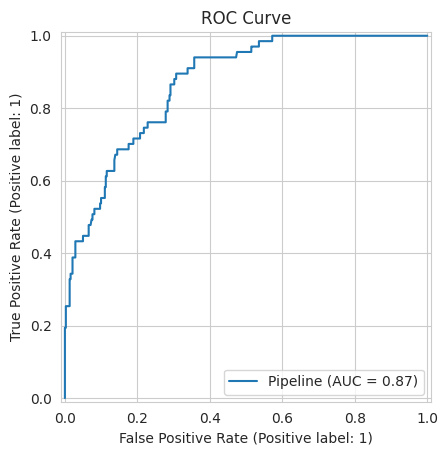

In [286]:
# AUC SCORE
auc = roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1])
print(f"AUC Score: {auc:.4f}")

# ROC Plot
RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)
plt.title('ROC Curve')
plt.show()

--- Training the model: Logistic Regression ---

--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       381
           1       0.38      0.73      0.50        67

    accuracy                           0.78       448
   macro avg       0.66      0.76      0.68       448
weighted avg       0.86      0.78      0.81       448

ROC AUC: 0.8696

--- Training the model: Random Forest ---


/tmp/ipython-input-4169700901.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({



--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       381
           1       0.80      0.30      0.43        67

    accuracy                           0.88       448
   macro avg       0.84      0.64      0.69       448
weighted avg       0.88      0.88      0.86       448

ROC AUC: 0.8680

--- Training the model: XGBoost ---

--- Classification Report for XGBoost ---
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       381
           1       0.64      0.42      0.50        67

    accuracy                           0.88       448
   macro avg       0.77      0.69      0.72       448
weighted avg       0.86      0.88      0.87       448

ROC AUC: 0.8832


--- Comparative Results's Table ---
                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
2              XGBoost  0.877232   0.863519  0.877232  0.866311  0.883163

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:41:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


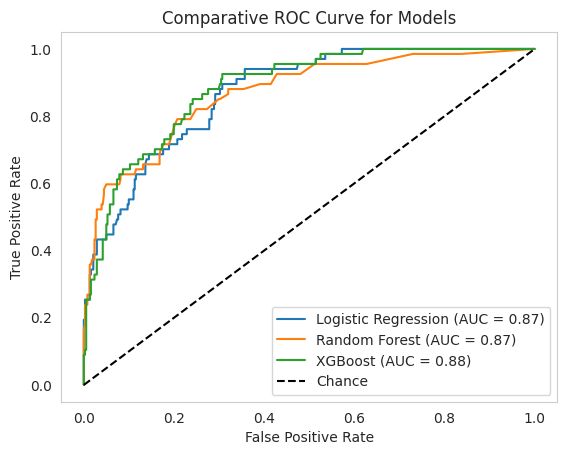

In [287]:
# Models Dictionary
# Key is the model's name, value is the classifier object
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# DataFrame to store the comparison results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

# Loop to train and evaluate each model using the Pipeline
for name, classifier in classifiers.items():
    print(f"--- Training the model: {name} ---")

    # Create the complete Pipeline: preprocessing + model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Fit the pipeline with the training data
    model_pipeline.fit(X_train, y_train)

    # Fit the pipeline with the training data
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"\n--- Classification Report for {name} ---")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}\n")

    # Store the results for comparison
    results = pd.concat([results, pd.DataFrame({
        'Model': [name],
        'Accuracy': [report['accuracy']],
        'Precision': [report['weighted avg']['precision']],
        'Recall': [report['weighted avg']['recall']],
        'F1-Score': [report['weighted avg']['f1-score']],
        'ROC AUC': [roc_auc]
    })], ignore_index=True)

    # ROC Curve - Current model
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


# Display the plots and the comparison table
print("\n--- Comparative Results's Table ---")

# Sort the results by F1-Score to identify the best model
results_sorted = results.sort_values(by='F1-Score', ascending=False)
print(results_sorted)

# Configure the comparative ROC Curve plot
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curve for Models')
plt.legend(loc='best')
plt.grid()
plt.show()

**6.1. Baseline Model Comparison**

Three different classification models were trained and evaluated to establish a performance baseline:

- Logistic Regression

- Random Forest

- XGBoost

Each model was integrated into a full pipeline with the preprocessing steps. Their performance was compared on the test set using **Accuracy, Precision, Recall, F1-Score, and ROC AUC**. A **comparative ROC curve was also plotted** to visualize their ability to distinguish between the two classes.

In [288]:
print("--- Tuning Hyperparameters for models with GridSearchCV ---")

# DATA SPLITTING (80/20 Train-Test Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. HYPERPARAMETER TUNING AND FEATURE IMPORTANCE LOOP ---

# Define the models and their parameter grids
models_and_params = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        "params": {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear', 'saga']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20],
            'classifier__min_samples_leaf': [2, 4]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.05, 0.1]
        }
    }
}

# Loop through each model to tune and analyze it
for name, mp in models_and_params.items():
    print(f"========== Tuning and Analyzing: {name} ==========")

    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', mp['model'])
    ])

    # Set up and run GridSearchCV
    grid_search = GridSearchCV(pipeline, mp['params'], cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV ROC AUC for {name}: {grid_search.best_score_:.4f}\n")

    best_model = grid_search.best_estimator_



--- Tuning Hyperparameters for models with GridSearchCV ---
========== Tuning and Analyzing: Logistic Regression ==========
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best CV ROC AUC for Logistic Regression: 0.8638

========== Tuning and Analyzing: Random Forest ==========
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200}
Best CV ROC AUC for Random Forest: 0.8779

========== Tuning and Analyzing: XGBoost ==========
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best CV ROC AUC for XGBoost: 0.8725



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:42:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**6.2. Hyperparameter Optimization with Cross-Validation**

To find the best possible version of each model, **GridSearchCV** was used. This process systematically tested various combinations of hyperparameters for each model using a **5-fold cross-validation scheme** on the training data. This provides a more **robust estimate** of each model's performance and helps **prevent overfitting**.

**7. Results Analysis and Business Insights**

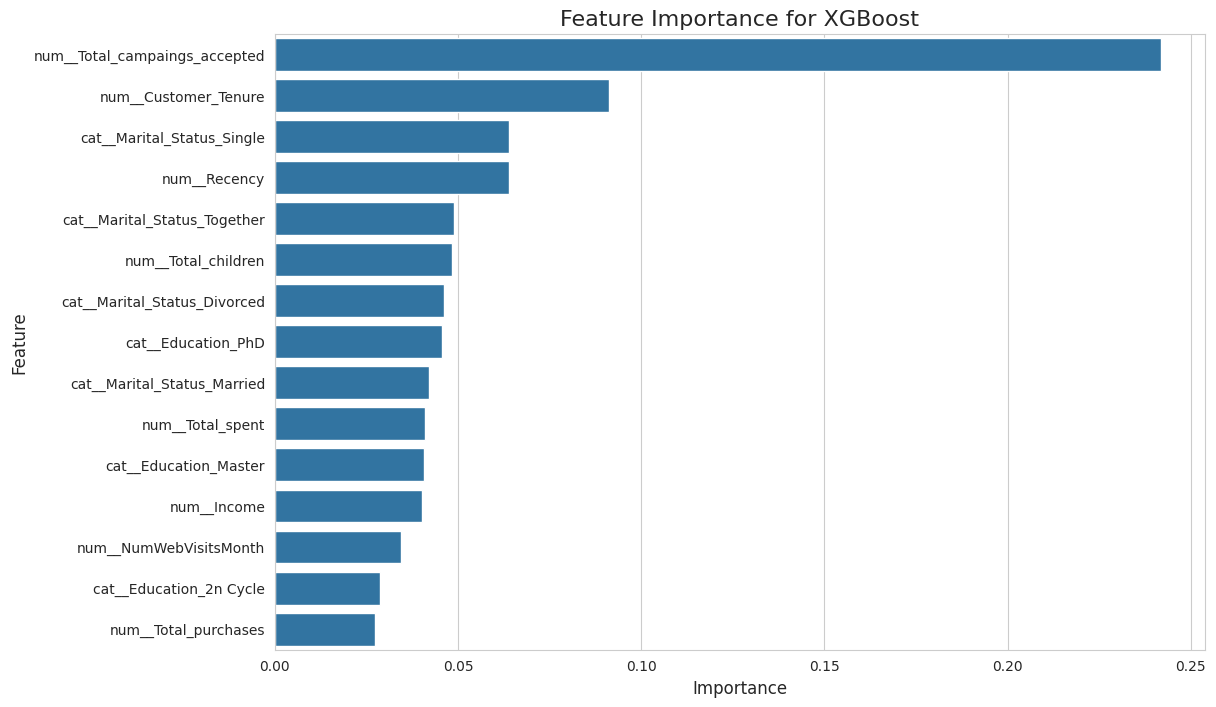

In [289]:
    # --- Feature Importance ---
    # Get feature names after transformation
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

    # Get importances based on model type
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        # For tree-based models (Random Forest, XGBoost)
        importances = best_model.named_steps['classifier'].feature_importances_
        importance_type = 'Importance'
    elif hasattr(best_model.named_steps['classifier'], 'coef_'):
        # For linear models (Logistic Regression), use absolute coefficient values
        importances = np.abs(best_model.named_steps['classifier'].coef_[0])
        importance_type = 'Absolute Coefficient'
    else:
        print(f"Could not extract feature importance for {name}")


    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title(f'Feature Importance for {name}', fontsize=16)
    plt.xlabel(importance_type, fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()
    print("\n\n")

**7.1. Feature Importance Analysis**

After identifying the best-tuned version of each model, a feature importance analysis was conducted. This step reveals which customer attributes are the most influential in predicting campaign acceptance. For tree-based models (Random Forest, XGBoost), Gini importance was used. For Logistic Regression, the absolute coefficient values were analyzed.

**7.2. Conclusion and Final Recommendation**

The analysis showed that all three models performed well, with **Random Forest achieving the highest robust cross-validated ROC AUC score (0.8779)**. The feature importance analysis consistently highlighted that a **customer's past engagement (Total_campaigns_accepted)** and their **relationship with the company (Customer_Tenure, Recency)** are the **most decisive factors**.

**Final Model Recommendation:**

- For **maximum predictive performance**, the **tuned Random Forest model is the best choice**.

- For a **balance of strong performance and high interpretability**, the **Logistic Regression model is an excellent alternative**, as it allows for a clear explanation of how each factor influences the outcome.

**Next Steps:**

- **Deploy the chosen model** to score new customers for upcoming campaigns.

- Use the insights from the feature importance analysis to **refine marketing strategy and personalize offers**.

- Periodically **retrain the model** with new data to **maintain its performance** over time.